In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [ ]:
import anndata
import scanpy as sc
import pandas as pd
from scipy import sparse
from modules.process_data import *
from collections import Counter
from matplotlib.ticker import PercentFormatter
from modules.process_data import mapping1, mapping2
from modules.utils import *

In [ ]:
def visualize_umap(X, Y):
    plt.figure(figsize=(10, 8))
    unique_targets = np.unique(cell_type)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_targets)))
    markersize_scatter = 0.1  
    markersize_legend = 10
    for target, color in zip(unique_targets, colors):
        indices = np.where(cell_type == target)
        plt.scatter(X[indices, 0], X[indices, 1], color=color, label=target, s=markersize_scatter)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=markersize_legend, label=target)
               for target, color in zip(unique_targets, colors)]
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

def get_clustering(umap_result, kmeans_result):
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(kmeans_result)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    for label, color in zip(unique_labels, colors):
        indices = np.where(kmeans_result == label)
        plt.scatter(umap_result[indices, 0], umap_result[indices, 1], color=color, label=f'Cluster {label}', s=0.1)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.grid(True)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {label}')
               for label, color in zip(unique_labels, colors)]
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def get_cluster_composition(kmeans_result, labels):
    clusters = np.unique(kmeans_result)
    cluster_composition = {}
    for cluster in clusters:
        indices = np.where(kmeans_result == cluster)[0]
        cluster_labels = labels[indices]
        counter = Counter(cluster_labels)
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        cluster_composition[cluster] = {y: count for y, count in sorted_counter.items()}
    return cluster_composition
    
def plot_cluster_composition(cluster_composition):
    cluster_labels = list(cluster_composition.keys())
    all_sub_labels = sorted({sub_label for comp in cluster_composition.values() for sub_label in comp.keys()})
    composition_matrix = np.zeros((len(cluster_labels), len(all_sub_labels)))
    for i, cluster in enumerate(cluster_labels):
        for j, sub_label in enumerate(all_sub_labels):
            composition_matrix[i, j] = cluster_composition[cluster].get(sub_label, 0)
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.jet(np.linspace(0, 1, len(all_sub_labels)))
    bottom = np.zeros(len(cluster_labels))
    for j, sub_label in enumerate(all_sub_labels):
        ax.bar(cluster_labels, composition_matrix[:, j], bottom=bottom, color=colors[j], label=sub_label)
        bottom += composition_matrix[:, j]
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Cell count')
    ax.set_title('Cluster Composition')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(cluster_labels)
    plt.grid(True)
    plt.show()

def get_pie_chart(cluster_data, min_pct=1):
    total = sum(cluster_data.values())
    sorted_cluster_data = {k: v for k, v in sorted(cluster_data.items(), key=lambda item: item[1], reverse=True)}
    top_labels, top_values, others_value = [], [], 0
    for label, value in sorted_cluster_data.items():
        percentage = (value / total) * 100
        if percentage < min_pct:
            others_value += value
        else:
            top_labels.append(label)
            top_values.append(value)
    if others_value > 0:
        top_labels.append('Others')
        top_values.append(others_value)
    jet = plt.get_cmap('jet')
    norm = plt.Normalize(0, len(top_labels))
    colors = [jet(norm(i)) for i in range(len(top_labels))]
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        top_values, labels=top_labels, autopct='%1.1f%%', colors=colors,
        startangle=90, counterclock=False
    )
    plt.setp(autotexts, size=10, weight="bold", color="white")
    plt.axis('equal')  
    plt.show()

In [ ]:
def filter_cells_by_gene_counts(adata, min_genes=200, max_genes=6000):
    nonzero_counts = (adata.X > 0).sum(axis=1)
    cell_mask = (nonzero_counts >= min_genes) & (nonzero_counts <= max_genes)
    filtered_adata = adata[cell_mask]
    return filtered_adata

def rm_high_mt(adata, threshold=0):
    mito_genes = [gene for gene in adata.var_names if gene.startswith('mt-')]
    total_counts = adata.X.sum(axis=1).A1 if isinstance(adata.X, np.matrix) else adata.X.sum(axis=1)
    mito_counts = adata[:, mito_genes].X.sum(axis=1).A1 if isinstance(adata.X, np.matrix) else adata[:, mito_genes].X.sum(axis=1)
    mito_percentage = mito_counts / total_counts
    cells_to_keep = mito_percentage <= threshold
    return adata[cells_to_keep, :]

In [ ]:
mapping = {'Multiplet': 'Multiplet',
           'SampleTag17_flex': 'WT-DMSO',
           'SampleTag18_flex': '3xTg-DMSO',
           'SampleTag19_flex': 'WT-SCDi',
           'SampleTag20_flex': '3xTg-SCDi',
           'Undetermined': 'Undetermined'}

In [ ]:
#load sc data
adata = anndata.read_h5ad("data/fede_count.h5ad")

In [ ]:
#data cleaning
adata = rm_high_mt(adata, threshold=0.6)
adata = filter_cells_by_gene_counts(adata)

In [ ]:
mt_genes = adata.var_names.str.startswith('mt-')
adata.X[:, mt_genes] = 0

In [ ]:
#normalize, log and scale data
sc.pp.normalize_total(adata, target_sum=1)
sc.pp.log1p(adata)
#sc.pp.scale(adata)

In [ ]:
#load annotation data
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('int64')

In [ ]:
#Create df with metadata - sample_tag and cell type
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sample_tags.index = sample_tags.index.astype('int64')
sample_tags = pd.DataFrame(sample_tags['Sample_Tag'].map(mapping))
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sc_df.index = sc_df.index.astype('int64')
sc_df = sc_df.join(sample_tags)
sc_df = sc_df.join(anno_df)

In [ ]:
#remove cell with sample tags "multiplet" or "undetermined"
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]

In [ ]:
#keep only a specific cell type
#sc_df = sc_df[sc_df["class_name"] == "30 Astro-Epen"]

In [ ]:
#split cell type, pheno and gene_expression 
X = sc_df.drop(['Sample_Tag', 'class_name'], axis=1).values
cell_pheno = sc_df['Sample_Tag'].values
cell_type = sc_df['class_name'].values

In [ ]:
#PCA dim. reduction
pca = PCA(n_components=10, random_state=42)
pca_result = pca.fit_transform(X)

In [ ]:
#UMAP dim. reduction
reducer = UMAP(n_neighbors=100, n_components=2, random_state=42)
umap_result = reducer.fit_transform(pca_result)

In [ ]:
#KMEANS clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_result = kmeans.fit_predict(umap_result)

In [ ]:
visualize_umap(umap_result, cell_type)

In [ ]:
get_clustering(umap_result, kmeans_result)

In [ ]:
cluster_composition = get_cluster_composition(kmeans_result, cell_type)

In [ ]:
get_pie_chart(cluster_composition[1], min_pct=5)

In [ ]:
wt_dmso = sc_df[sc_df['Sample_Tag'] == 'WT-DMSO'].drop(['class_name', 'Sample_Tag'], axis=1)

In [ ]:
tg_dmso = sc_df[sc_df['Sample_Tag'] == '3xTg-DMSO'].drop(['class_name', 'Sample_Tag'], axis=1)

In [ ]:
# Combine the data into a single DataFrame
combined_data = pd.concat([wt_dmso, tg_dmso], axis=0)
labels = ['wt'] * wt_dmso.shape[0] + ['tg'] * tg_dmso.shape[0]

# Create AnnData object
adata = sc.AnnData(combined_data)
adata.obs['condition'] = labels

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

# Handle potential NaNs or infinite values
adata.raw = adata  # Save the raw data before filtering
adata = adata[:, adata.var['highly_variable']]

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='condition', method='t-test')

# Extract results and ensure proper numerical values
degs = adata.uns['rank_genes_groups']
pvals = degs['pvals']['tg']  # Extract p-values for the 'tg' group
logfoldchanges = degs['logfoldchanges']['tg']  # Extract log fold changes for the 'tg' group
genes = degs['names']['tg']  # Extract gene names for the 'tg' group

# Adjust p-values for multiple testing using the Benjamini-Hochberg procedure
adjusted_pvals = multipletests(pvals, method='fdr_bh')[1]

In [ ]:
# Create a DataFrame for plotting
volcano_data = pd.DataFrame({
    'gene': genes,
    'log2_fold_change': logfoldchanges,
    'p_value': pvals,
    'adjusted_p_value': adjusted_pvals
})

# Calculate -log10(p-value)
volcano_data['-log10_p_value'] = -np.log10(volcano_data['adjusted_p_value'])

# Plot the volcano plot
plt.figure(figsize=(10, 8))

# Plot non-significant points in gray
plt.scatter(volcano_data['log2_fold_change'], volcano_data['-log10_p_value'], c='black', alpha=0.5, s=10)

# Highlight significant genes
significant = volcano_data['adjusted_p_value'] < 0.01

# Plot significant points: red for positive log2 fold change, blue for negative
plt.scatter(volcano_data.loc[significant & (volcano_data['log2_fold_change'] > 0), 'log2_fold_change'],
            volcano_data.loc[significant & (volcano_data['log2_fold_change'] > 0), '-log10_p_value'],
            c='red', s=10)

plt.scatter(volcano_data.loc[significant & (volcano_data['log2_fold_change'] < 0), 'log2_fold_change'],
            volcano_data.loc[significant & (volcano_data['log2_fold_change'] < 0), '-log10_p_value'],
            c='blue', s=10)

# Calculate the number of significant DEGs
upregulated = significant & (volcano_data['log2_fold_change'] > 0)
downregulated = significant & (volcano_data['log2_fold_change'] < 0)
num_upregulated = upregulated.sum()
num_downregulated = downregulated.sum()

# Annotate the number of DEGs
plt.text(-14, max(volcano_data['-log10_p_value']) - 1, f'{num_downregulated} DEGs', color='blue', fontsize=12)
plt.text(14, max(volcano_data['-log10_p_value']) - 1, f'{num_upregulated} DEGs', color='red', fontsize=12, horizontalalignment='right')

# Annotate some top genes
top_genes = volcano_data[significant].nlargest(10, '-log10_p_value')
for i, row in top_genes.iterrows():
    plt.text(row['log2_fold_change'], row['-log10_p_value'], row['gene'], fontsize=8)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano plot (wt_dmso vs tg_dmso DEGs)')
plt.show()

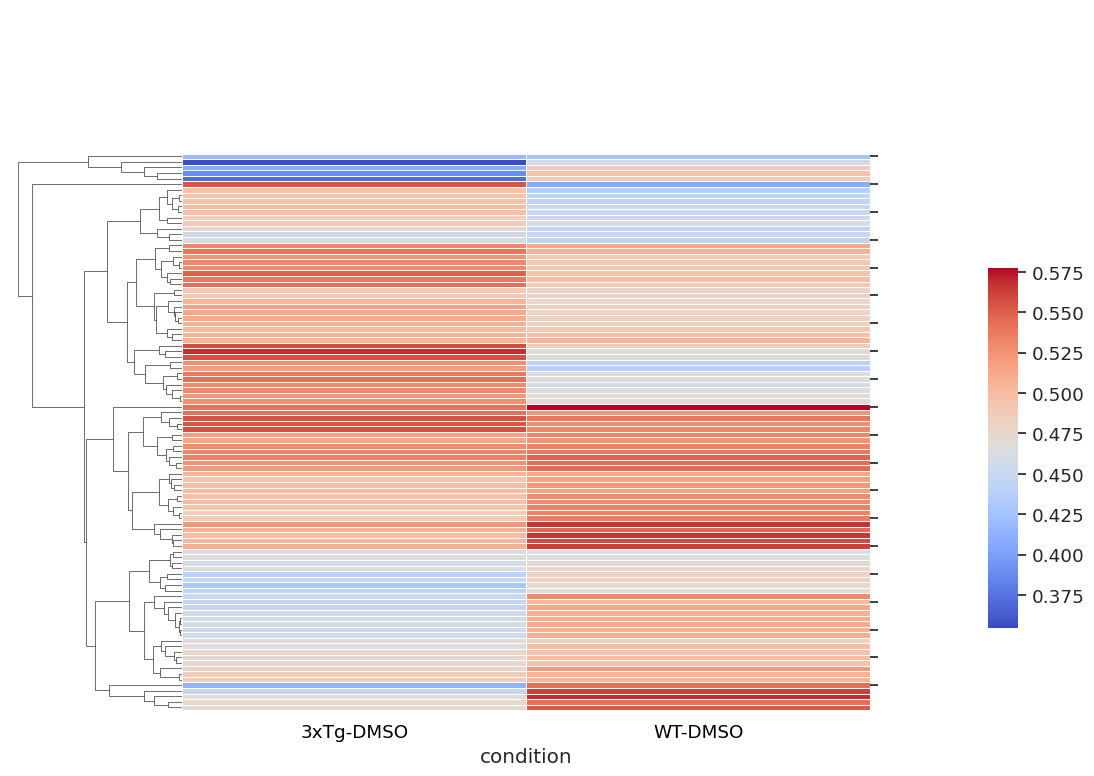

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a toy dataset
np.random.seed(0)
n_genes = 100
n_cells = 100
genes = [f'Gene{i}' for i in range(1, n_genes + 1)]
conditions = ['WT-DMSO', '3xTg-DMSO']

# Generate random expression data
data = np.random.rand(n_cells, n_genes)
cell_conditions = np.random.choice(conditions, n_cells)

# Create an AnnData object
adata = sc.AnnData(X=data, obs={'condition': cell_conditions}, var=pd.DataFrame(index=genes))

# Select some top genes (in this case, all genes)
top_genes = pd.DataFrame({'gene': genes})

# Subset the data to the top genes
markers = top_genes['gene'].values
adata_subset = adata[:, markers]

# Average expression per condition
mean_expression = adata_subset.to_df().groupby(adata_subset.obs['condition']).mean()

# Transpose the dataframe to have genes as rows and conditions as columns
heatmap_data = mean_expression.T

# Create a color palette for the conditions
condition_colors = {
    'WT-DMSO': 'black',  
    '3xTg-DMSO': 'black',  
}

# Create a color palette list for conditions
condition_palette = [condition_colors[condition] for condition in heatmap_data.columns]

# Generate a clustermap without the condition dendrogram
sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(
    heatmap_data,
    cmap='coolwarm',
    linewidths=.5,
    figsize=(10, 8),
    #col_colors=condition_palette,
    row_cluster=True,  # Cluster rows (genes)
    col_cluster=False  # Do not cluster columns (conditions)
)

# Customize the condition colors (color bar)
for tick_label, tick_color in zip(cg.ax_heatmap.get_xticklabels(), condition_palette):
    tick_label.set_color(tick_color)

# Hide the gene names on the right
cg.ax_heatmap.set_yticklabels([])

# Move the color legend to the right
cg.cax.set_position([1, .2, .03, .45])

# Show the plot
plt.show()


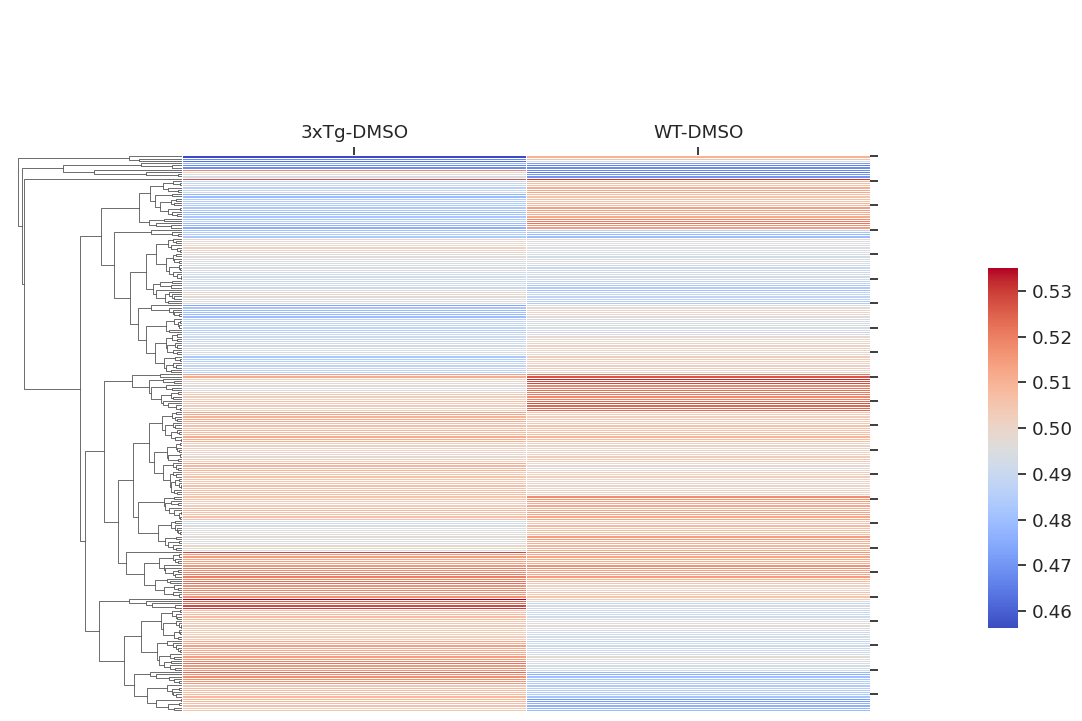

In [18]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a toy dataset
np.random.seed(0)
n_genes = 250
n_cells = 1000
genes = [f'Gene{i}' for i in range(1, n_genes + 1)]
conditions = ['WT-DMSO', '3xTg-DMSO']

# Generate random expression data
data = np.random.rand(n_cells, n_genes)
cell_conditions = np.random.choice(conditions, n_cells)

# Create an AnnData object
adata = sc.AnnData(X=data, obs={'condition': cell_conditions}, var=pd.DataFrame(index=genes))

# Select some top genes (in this case, all genes)
top_genes = pd.DataFrame({'gene': genes})

# Subset the data to the top genes
markers = top_genes['gene'].values
adata_subset = adata[:, markers]

# Average expression per condition
mean_expression = adata_subset.to_df().groupby(adata_subset.obs['condition']).mean()

# Transpose the dataframe to have genes as rows and conditions as columns
heatmap_data = mean_expression.T

# Create a color palette for the conditions
condition_colors = {
    'WT-DMSO': 'black',  
    '3xTg-DMSO': 'black',  
}

# Create a color palette list for conditions
condition_palette = [condition_colors[condition] for condition in heatmap_data.columns]

# Generate a clustermap without the condition dendrogram
sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(
    heatmap_data,
    cmap='coolwarm',
    linewidths=.5,
    figsize=(10, 8),
    row_cluster=True,  # Cluster rows (genes)
    col_cluster=False  # Do not cluster columns (conditions)
)

# Customize the condition colors (color bar)
for tick_label, tick_color in zip(cg.ax_heatmap.get_xticklabels(), condition_palette):
    tick_label.set_color(tick_color)

# Hide the gene names on the right
cg.ax_heatmap.set_yticklabels([])

# Move the color legend to the right
cg.cax.set_position([1, .2, .03, .45])

# Move the column labels to the top and center them
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()

# Center the x-tick labels
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_ha('center')

# Remove the 'Condition' word
cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=0)

#plt.ylabel('')

# Show the plot
plt.show()
